In [14]:
import deepcell

In [1]:
import skimage.io as sio
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../../scripts/')

from paths import get_data_paths

In [2]:
data_path = get_data_paths('../../../data_mapping.yml')['mouse_gut']

In [3]:
dapi = sio.imread(data_path / 'raw_data' / 'dapi_stack.tif')
membrane = sio.imread(data_path / 'raw_data' / 'membrane_stack.tif')

In [4]:
X = np.concatenate([dapi[4:5], membrane[4:5]])
X = X.reshape(1, *X.shape)
X = X.transpose((0, 2, 3, 1))

In [38]:
from deepcell.utils.plot_utils import create_rgb_image

# create rgb overlay of image data for visualization
rgb_images = create_rgb_image(X, channel_colors=['green', 'red'])

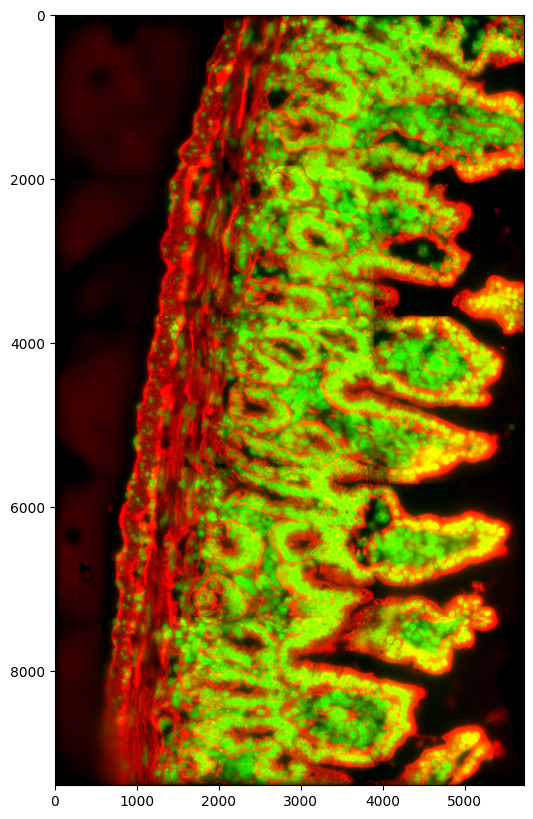

In [39]:
plt.figure(figsize=(10, 10))
plt.imshow(rgb_images[0])

## Export

In [7]:
from skimage.transform import rescale, resize

In [6]:
IMG_PATH = data_path / 'seg_method_results' / 'deepcell'

In [90]:
# sio.imsave(f'{IMG_PATH}/test.tif', X[0][::5, ::5])

In [8]:
um_per_pixel = 0.109
target_um_per_pixel = 0.5
um_per_pixel / target_um_per_pixel

0.218

In [150]:
X_rescaled = rescale(X[0], 0.218, channel_axis=2) # target: 0.5
split_id = X_rescaled.shape[1]
X_rescaled.shape

(2047, 1247, 2)

Max resolution is 2048 per slide, so it just fits.

In [117]:
sio.imsave(f'{IMG_PATH}/input/slide.tif', X_rescaled)

In [123]:
um_per_pixel / 0.1667

0.6538692261547691

In [149]:
X_rescaled_hr = rescale(X[0], 0.654, channel_axis=2) # target: 0.1667
print(X_rescaled_hr.shape)
X_rescaled_hr = X_rescaled_hr[:2048,:2048,:]

(6142, 3742, 2)


In [126]:
sio.imsave(f'{IMG_PATH}/input/slide1_hr.tif', X_rescaled_hr)

## Show results

In [178]:
import cv2

import numpy as np
from skimage import measure
from tqdm.auto import tqdm

def segmentation_to_polygons(label_mask: np.ndarray):
    label_mask = np.asarray(label_mask)
    unique_labels = np.unique(label_mask)

    polygons = []
    for label in unique_labels:
        contours = measure.find_contours((label_mask == label).astype(float))
        polygons.extend(contours)

    return polygons

In [190]:
img = X_rescaled_hr
img = img.reshape(1, *img.shape)
X_rescaled_hr_rgb = create_rgb_image(img, channel_colors=['green', 'red'])[0]

img = X_rescaled
img = img.reshape(1, *img.shape)
X_rescaled_rgb = create_rgb_image(img, channel_colors=['green', 'red'])[0]

In [166]:
seg_05 = [sio.imread(f'{IMG_PATH}/output/slide_feature_{i}.tif')[0] for i in [0, 1]]
seg_016 = [sio.imread(f'{IMG_PATH}/output/slide1_hr_feature_{i}.tif')[0] for i in [0, 1]]

In [15]:
[int(s.max()) for s in seg_05]

[3116, 2965]

In [ ]:
# contours_05 = cv2.findContours(seg_05[1].astype(np.uint16), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
# contours_016 = cv2.findContours(seg_016[1].astype(np.uint16), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

In [184]:
contours_05, contours_016 = [
    [segmentation_to_polygons(s.astype(int)) for s in tqdm(seg)]
    for seg in [seg_05, seg_016]
]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

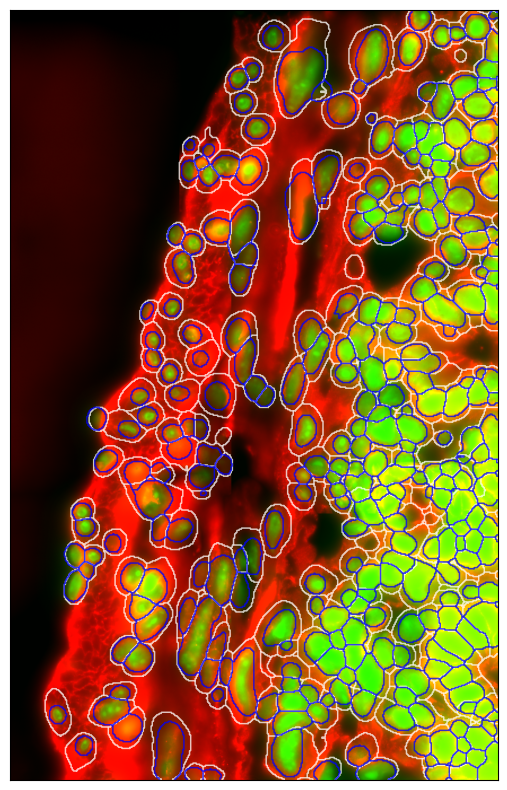

In [209]:
plt.figure(figsize=(10, 10))
plt.imshow(X_rescaled_hr_rgb)
for ps,t,c in zip(contours_016, ['Membrane', 'DAPI'], ['white', 'blue']):
    for p in ps:
        plt.plot(p[:,1], p[:,0], color=c, alpha=0.5, lw=1)

plt.xlim(750, None);
plt.xticks([]); plt.yticks([]);

In [206]:
[x * 0.218 / 0.654 for x in [750, 2048]]

[250.0, 682.6666666666666]

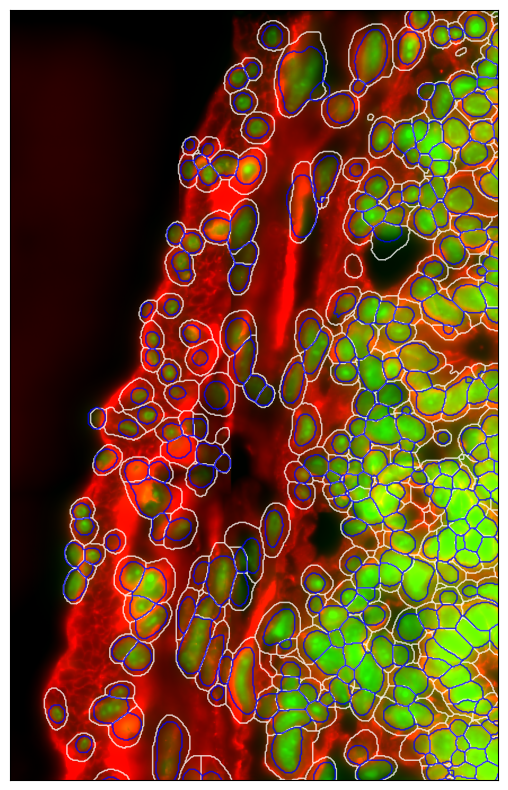

In [208]:
plt.figure(figsize=(10, 10))
plt.imshow(X_rescaled_rgb)
for ps,t,c in zip(contours_05, ['Membrane', 'DAPI'], ['white', 'blue']):
    for p in ps:
        plt.plot(p[:,1], p[:,0], color=c, alpha=0.5, lw=1)

plt.xlim(250, 683); plt.ylim(683, 0);
plt.xticks([]); plt.yticks([]);

In [148]:
contours[2].shape

(29, 1, 2)

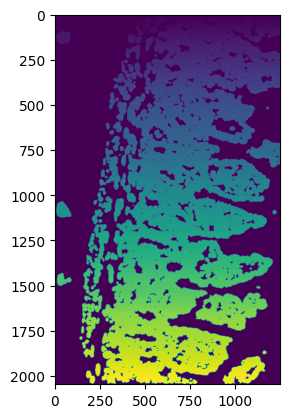

In [138]:
plt.imshow(seg_05[0][0])